# Retina Net Implementation for Pneumonia Detection

In [0]:
# Clone the git for RetinaNet implementation
!git clone "https://github.com/fizyr/keras-retinanet.git"

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5439 (delta 0), reused 3 (delta 0), pack-reused 5436
Receiving objects: 100% (5439/5439), 13.32 MiB | 31.43 MiB/s, done.
Resolving deltas: 100% (3638/3638), done.


In [0]:
# Install the pre-requisites and import required libraries
!pip install pydicom
import glob, pylab, pandas as pd
import numpy as np
import matplotlib.image as image
import pydicom as dcm
#from skimage.transform import resize

In [0]:
#Mount drive to access the files in google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd keras-retinanet

/content/keras-retinanet/keras-retinanet


In [0]:
# Install the required directory
!pip install .

Processing /content/keras-retinanet/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169847 sha256=b6d59f8995edbc14af7539bcee5682a03e34d4a10fc532b107f84b16b42a5179
  Stored in directory: /root/.cache/pip/wheels/cd/57/f4/f71ed948102bf00ffcf4eed03f64026c8935c9e71edfb34035
Successfully built keras-retinanet
  Found existing installation: keras-retinanet 0.5.1
    Uninstalling keras-retinanet-0.5.1:
      Successfully uninstalled keras-retinanet-0.5.1


In [0]:
# Compile the script using the setup file
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/ut

In [0]:
# Read the labels file
detailed_class_df = pd.read_csv('/content/drive/My Drive/GL Capstone Project/Dataset/stage_2_train_labels.csv')

In [0]:
# Filter records with pnuemonia cases
detailed_class_df=detailed_class_df[detailed_class_df['Target']==1]

In [0]:
# Group images with different bounding boxes
def parse_data(df):
    extract_box = lambda row: [row['x'], row['y'], row['width'], row['height']]
    parsed = {}
    for n, row in df.iterrows():
        
        pid = row['patientId']
        if pid not in parsed:
            parsed[pid] = {
                'boxes': []}
        parsed[pid]['boxes'].append(extract_box(row))

    return parsed

In [0]:
# Convert dcm file to JPEG for usage in RetinaNet
def converttoJpeg(patientId):
    dicom_file = dcm.read_file(inp_path+patientId+'.dcm')
    dicom_array = dicom_file.pixel_array
    #image_array = resize(dicom_array, (512, 512), mode= 'constant', anti_aliasing=True)
    image.imsave(out_path+patientId+".jpg", dicom_array)

In [0]:
# Get the first 4000 records for training
train_dict=parse_data(detailed_class_df.head(4000))

In [0]:
# Remove CSV files in case they are already available
import os
os.remove("annotate.csv")
os.remove("class.csv")

FileNotFoundError: ignored

In [0]:
#set path to the file location
out_path = '/content/drive/My Drive/GL Capstone Project/Dataset/JPEG/'
inp_path = '/content/drive/My Drive/GL Capstone Project/Dataset/stage_2_train_images/'

In [0]:
# Create annotation file for the images of the format image_path,x1,y1,x2,y3,'pnenumonia'
# Create class label file of the format 'pneumonia',0
for patient_id in train_dict.keys():
    box =train_dict[patient_id]['boxes']
    #converttoJpeg(patient_id)
    path = out_path+patient_id+".jpg"
    for j in range(len(box)):
      x1 = int(box[j][0])             #Upper lef 
      x2 = int(box[j][0] + box[j][2])
      y1 = int(box[j][1])
      y2 = int(box[j][1] + box[j][3]) #Upper left y1 + height  
      towrite = str(path+ "," + str(x1) + ","+ str(y1)+","+ str(x2)+","+ str(y2)+",Pneumonia")
      with open("annotate.csv", "a") as wr:
            wr.write(towrite)
            wr.write('\n')
      with open("class.csv", "w") as wr:
            towrite = str("Pneumonia,0")
            wr.write(towrite)

In [0]:
# Load pre-trained model weights
import urllib
#PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'
PRETRAINED_MODEL = './snapshots/resnet50_csv_10.h5'
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

('./snapshots/resnet50_csv_10.h5', <http.client.HTTPMessage at 0x7ff7dee5c080>)

In [0]:
!pip install keras==2.3.0

     |████████████████████████████████| 378kB 3.4MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 32 --steps 100 --epochs 10 csv annotate.csv class.csv

Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 9) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((9,) vs (720,)).
  weight_values[i].shape))
2020-01-19 09:58:42.782841: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-01-19 09:58:42.839452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-01-19 09:58:42.840006: I tensorflow/co

In [0]:
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
import matplotlib.pyplot as plt
import cv2

In [0]:
model_path='/content/keras-retinanet/snapshots/resnet50_csv_10.h5'
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors


In [0]:
THRES_SCORE = 0.3

In [0]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  image = preprocess_image(image)
  image, scale = resize_image(image)

  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

  boxes /= scale

  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      if score < THRES_SCORE:
          break
      color = label_color(label)
      print(color)
      b = box.astype(int)
      draw_box(draw, b, color=color)
      caption = "{} {:.2f}".format('pnuemonia', score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

Output

[31, 0, 255]
[31, 0, 255]


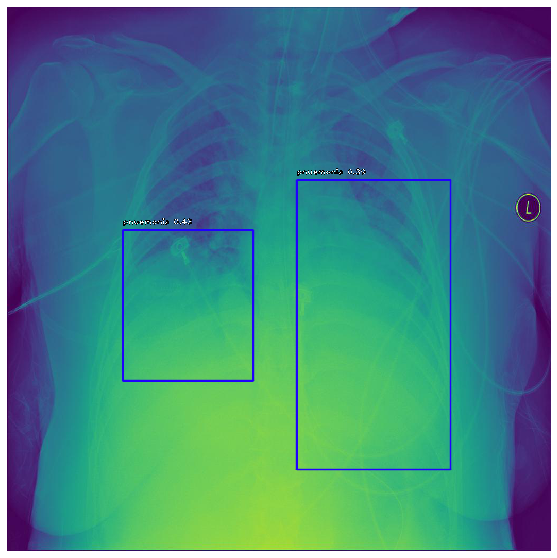

In [0]:
#Predicted Image
img_infer = '/content/drive/My Drive/GL Capstone Project/Dataset/JPEG/00436515-870c-4b36-a041-de91049b9ab4.jpg'
img_inference(img_infer)

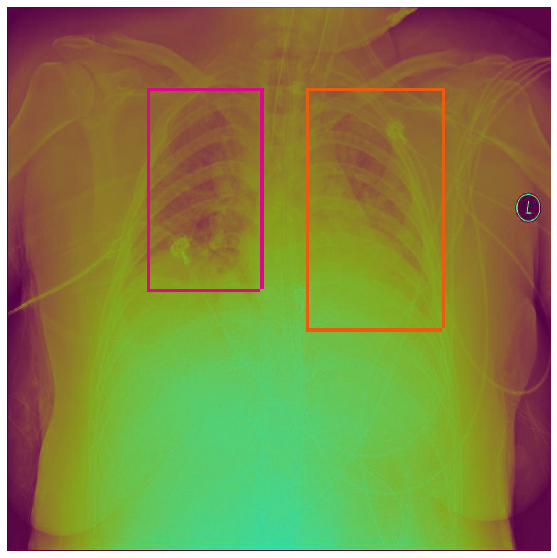

In [0]:
patient_id='00436515-870c-4b36-a041-de91049b9ab4'
draw_BB(patient_id)

In [0]:
def draw_BB(patient_id):
    file_path = inp_path + patient_id+'.dcm'
    d = read_image_bgr(out_path + patient_id+'.jpg')
    #d = dcm.read_file(file_path)
    #im = d.pixel_array
    # --- Convert from single-channel grayscale to 3-channel RGB
    #im = np.stack([im] * 3, axis=2)
    data = train_dict[patient_id]
    for box in data['boxes']:
        #rgb = np.floor(np.random.rand(3) * 256).astype('int')
        rgb=[31, 0, 255]
        im = overlay_box(im=d, box=box, rgb=rgb, stroke=6)

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(d)
    plt.show()

def overlay_box(im, box, rgb, stroke=1):
    
    # --- Convert coordinates to integers
    box = [int(b) for b in box]
    
    # --- Extract coordinates
    x1, y1, width, height = box
    y2 = y1 + height
    x2 = x1 + width

    im[y1:y1 + stroke, x1:x2] = rgb
    im[y2:y2 + stroke, x1:x2] = rgb
    im[y1:y2, x1:x1 + stroke] = rgb
    im[y1:y2, x2:x2 + stroke] = rgb

    return im

[31, 0, 255]
[31, 0, 255]


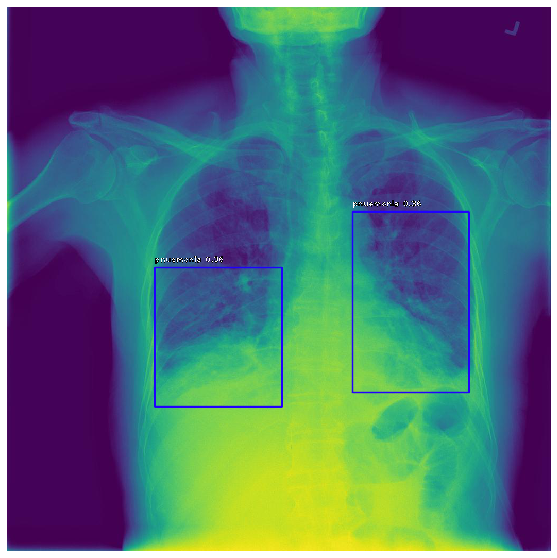

In [0]:
#Predicted Image
img_infer = '/content/drive/My Drive/GL Capstone Project/Dataset/JPEG/00704310-78a8-4b38-8475-49f4573b2dbb.jpg'
img_inference(img_infer)

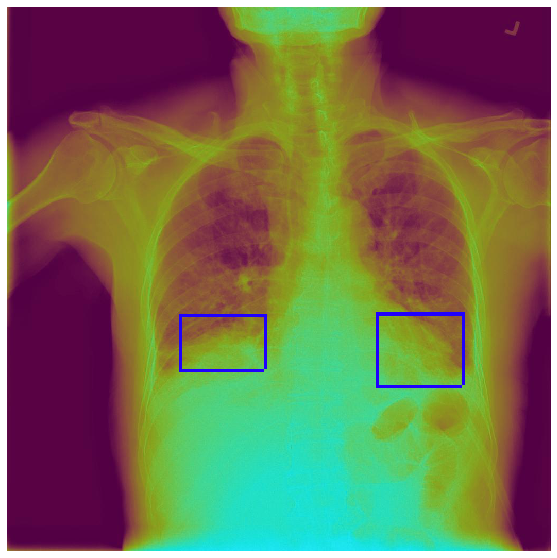

In [0]:
patient_id='00704310-78a8-4b38-8475-49f4573b2dbb'
draw_BB(patient_id)

[31, 0, 255]
[31, 0, 255]
[31, 0, 255]


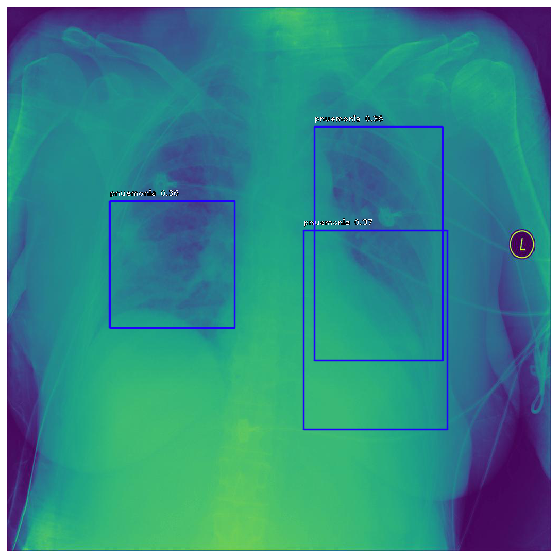

In [0]:
#Predicted Image
THRES_SCORE = 0.35
img_infer = '/content/drive/My Drive/GL Capstone Project/Dataset/JPEG/01adfd2f-7bc7-4cef-ab68-a0992752b620.jpg'
img_inference(img_infer)

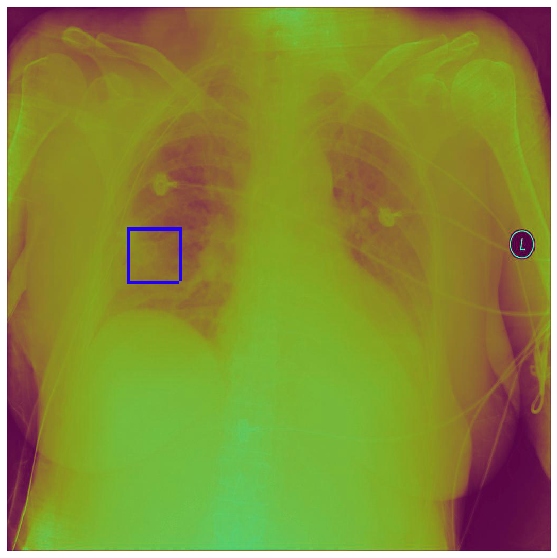

In [0]:
patient_id='01adfd2f-7bc7-4cef-ab68-a0992752b620'
draw_BB(patient_id)